# Inputs

In [ ]:
#typical libraries
import matplotlib.pyplot as plt 
import numpy as np 
from tensorflow import keras


In [ ]:
from keras.datasets import cifar10 #to load the data
from keras.utils import np_utils #for the encoding to transform the labels in categorical
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D #import the layers
from keras.models import Sequential #import the model
from tensorflow.keras import optimizers #import the optimizer
from keras.callbacks import Callback #import the callback
from keras.preprocessing import image #for visualisation of the image data
from keras import backend as K #for cleaning the memory

# Load, Split and Normalize the data

In [ ]:
#loading the data to x1 and x2
(x1, _), (x2,_) = cifar10.load_data()

In [ ]:
#normalize the data
x = np.vstack((x1,x2))
x = x / 255

#divining the data into training, test and validation 
(x_train,x_val,x_test) = np.vsplit(x,np.array([48000,54000]))
assert x_train.shape == (48000,32,32,3) #80%
assert x_val.shape == (6000,32,32,3) #10%
assert x_test.shape == (6000,32,32,3) #10%

#Visualisation of the data

In [ ]:
#loop to print the first 10 images of the wanted package 
def show_data(X , n =10,  height =16, width =32 ,title=""):
  plt.figure(figsize=(15,5))
  for i in range(n):
    ax = plt.subplot(2,n,i+1)
    plt.imshow(image.array_to_img(X[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.suptitle(title, fontsize = 20)

In [ ]:
#printing the size
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)
#images of 32x32 pixels and 3 RGB channels

(48000, 32, 32, 3)
(6000, 32, 32, 3)
(6000, 32, 32, 3)


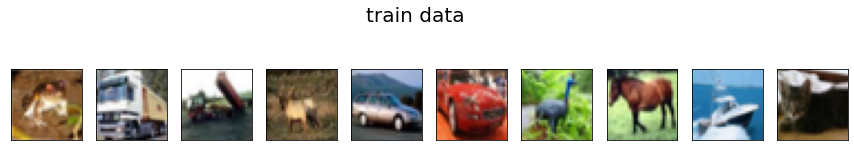

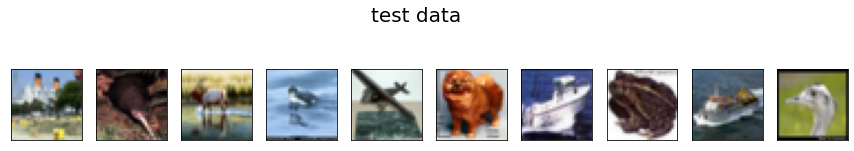

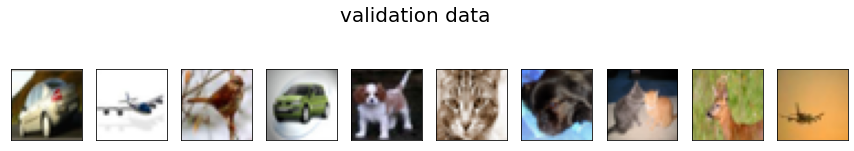

In [ ]:
#checking how the images look like, setting our test train and validation data
show_data(x_train, title = 'train data')
show_data(x_test, title = 'test data')
show_data(x_val, title = 'validation data')

#Neural Network Model

With the sequential model we are going to add layer after layer and then evaluate them in a sequential way. 
The architect  we are using is:

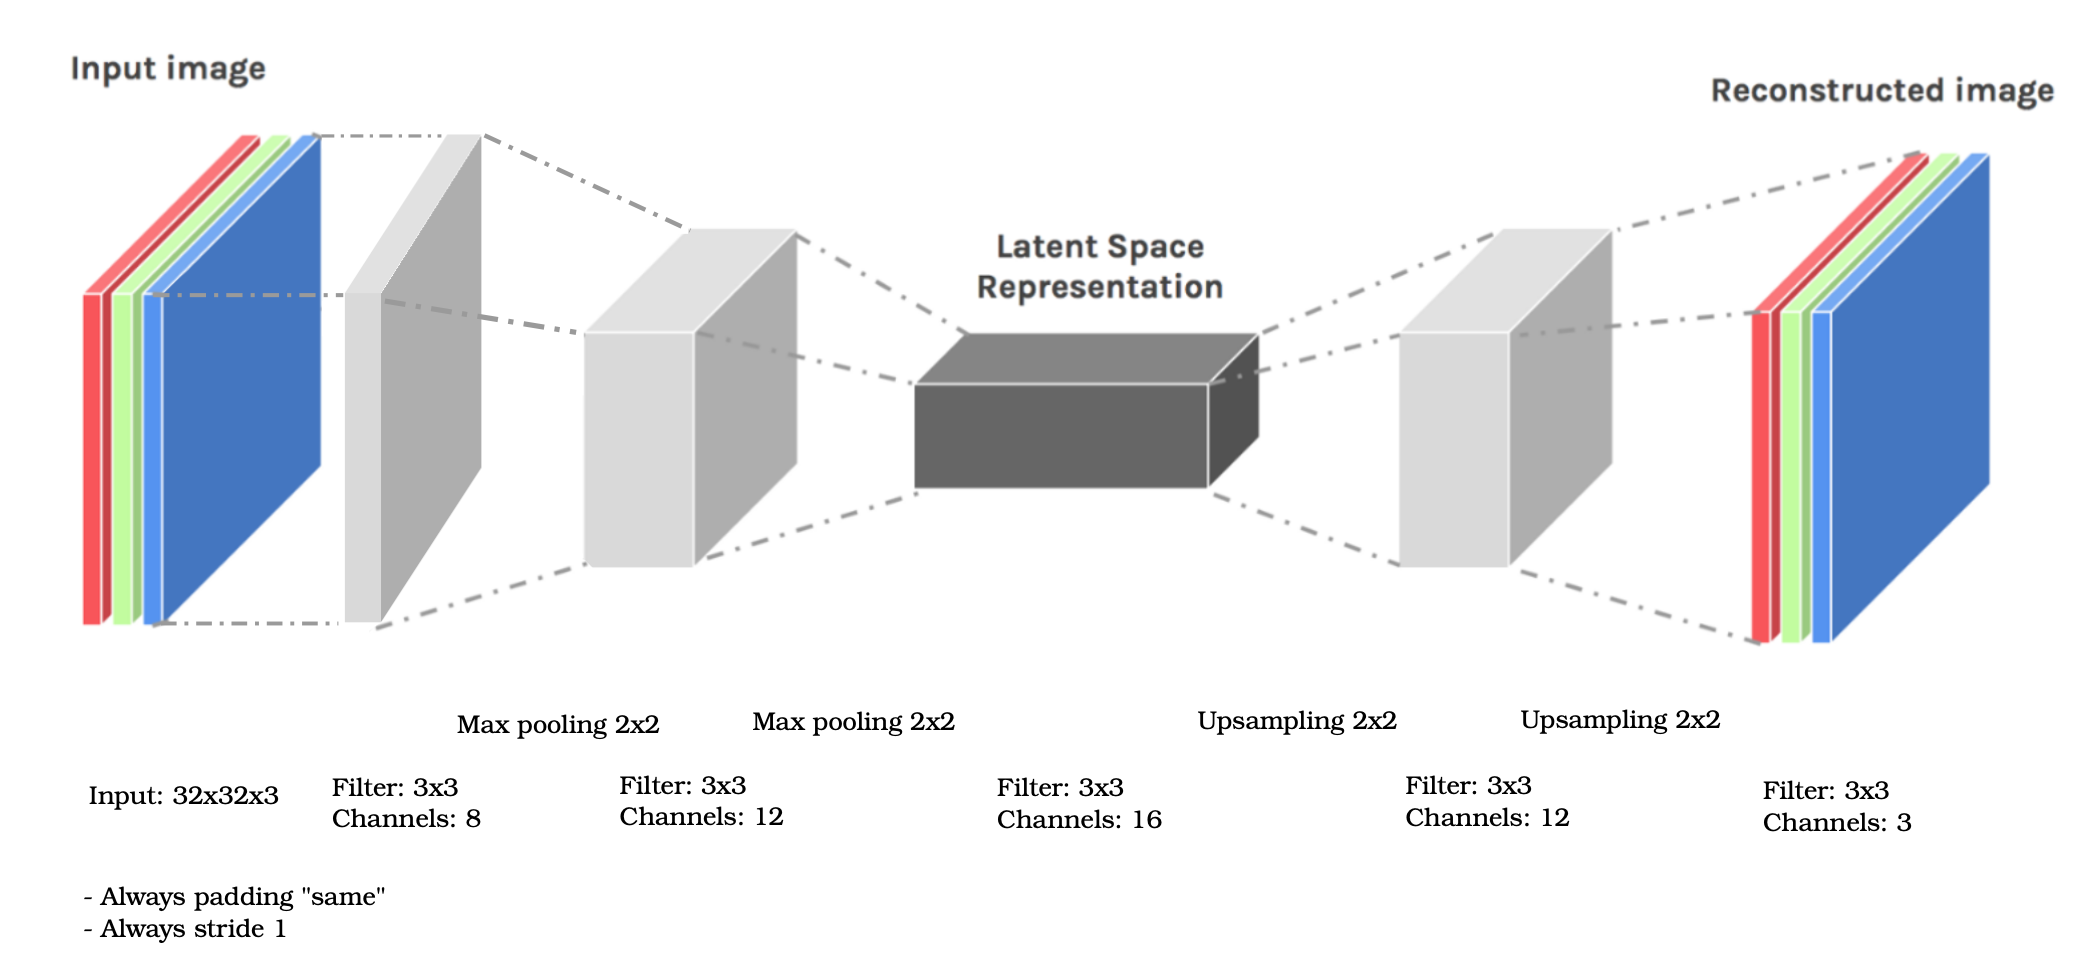

At this point we are splitting our architecture into the encoding and decoding phase.
For the encoding phase we :


*  Apply a first convolutional layer of 8 filters each sized 3x3 with padding such as to make the input perfectly divisible by the stride. The stride itself is one, meaning that the filters move one pixel column at a time while the activation function that shapes the filters is a rectified linear ( max (0,x) )
*  Apply a maxpooling layer sized 2x2 to downsample our input to a more managable level and make the computations lighter. Essentially reducing the input by a factor of 4
*  Apply a second convolutional layer of 12 filters and otherwise the same features as the first
*  Apply a second maxpooling layer 2x2 to further reduce the size our feature map outputs of the previous layer 
*  Apply a last convolutional layer of 16 filters with the same hyper parameters.

At this point we have reached the most encoded representation of our data in our current architecture. The next steps are involving the decoding of this compressed data to reach the reconstructed image

For the decoding phase we :

*  Apply an upsampling layer 2x2 which reverts the downsampling we performed earlier.
*  Apply a convolutional layer of 12 filters just as before.
*  Apply one more upsampling layer 2x2 to bring the output back to the original image size reverting in total the two downsamplings we did before, filling in the new values with the expected image patterns.
*  Apply a final convolutional layer of 3 filters that produces the RGB values and is activated by a sigmoid.





In [ ]:
#the input images
input_shape = (32,32,3)

In [ ]:
#using sequential model 
encoder = Sequential([
          #input layer
          Input(shape =input_shape, name= "INPUT"),
          #using  ReLU as activation function
          Conv2D(8, kernel_size=(3,3), padding = 'same',  activation = 'relu'),
          MaxPooling2D(pool_size =2),
          Conv2D(12, kernel_size=(3,3), padding = 'same', activation = 'relu'),
          MaxPooling2D(pool_size =2),
          Conv2D(16, kernel_size=(3,3), padding = 'same',  activation = 'relu')
    ])

decoder = Sequential([
          UpSampling2D(size =(2,2)),
          Conv2D(12, kernel_size=(3,3), padding = 'same',  activation = 'relu'),
          UpSampling2D(size =(2,2)),
          #using  sigmoid as activation function
          Conv2D(3, kernel_size=(3,3), padding = 'same', activation = 'sigmoid')
    ])


Parameters we want for the compile method :
*  the Adam optimizer as extracted by keras
*  binary_crossentropy as a loss function.
*  the accuracy parameter as a metric to check how thing are going



In [ ]:
#clear season to put everything out of memory
K.clear_session()
#creating the model
model = Sequential([encoder,decoder])

#defining the optimizer Adam
AdamOpt = keras.optimizers.Adam(learning_rate=0.01)
#compile the model
model.compile(optimizer = AdamOpt, loss = 'binary_crossentropy',metrics= ['accuracy'])

#Custome Call Back class for loging 

Every time an epoch ends this function runs and prints the results.

We are printing the results of every one epoch to see 
*  In what epoch we are
*  What is the loss
*  What is the loss evaluated on the validation dataset
*  The accuracy reached on the training dataset
*  The accuracy reached on the validation dataset
Printing both accuracies helps as compare them to make sure we are not overfitting.
All the Information can be found in the logs dictionary 



In [ ]:
class CustomCallback(Callback):
  #function the prints out the output that we want 
  def on_epoch_end(self, epoch, logs={}):
    #after every fifty epochs
    if (epoch % 50 == 0):
      print()
      print("Epoch: ", epoch)
      print()
      print("Loss: ", logs.get('loss'))
      print("Validation Loss: ", logs.get('val_loss'))
      print("Accuracy training: ", logs.get('accuracy'))
      print("Accuracy validation: ", logs.get('val_accuracy'))
      return

# Training of the network

In the model fit were we give data for:
*   training x,y our dataset
*   the batch size
*   how many epochs
*   With verbose=0, making sure we dont want any debugging outputs, because we have provided our own class do that. Otherwise for every epoch it will print out some debugging Information that slow down everything because of a lot input and output 
*  the validation data set because we want to make sure that we are not over fitting







In [ ]:
#defining the bach size and the epochs
batch_size = 256
epochs = 5000

#initiate the class
CC = CustomCallback()

#fiting the model and giving the training data as input and output
history = model.fit(x_train, x_train, batch_size = batch_size, epochs = epochs, verbose =0, validation_data = (x_val, x_val),callbacks = [CC])


Epoch:  0

Loss:  0.5889489650726318
Validation Loss:  0.571435272693634
Accuracy training:  0.5672349333763123
Accuracy validation:  0.6501064300537109

Epoch:  50

Loss:  0.5589116811752319
Validation Loss:  0.5644962787628174
Accuracy training:  0.7657410502433777
Accuracy validation:  0.7270349860191345

Epoch:  100

Loss:  0.558185338973999
Validation Loss:  0.5604657530784607
Accuracy training:  0.7685789465904236
Accuracy validation:  0.7688541412353516

Epoch:  150

Loss:  0.5576604604721069
Validation Loss:  0.5586666464805603
Accuracy training:  0.7718881964683533
Accuracy validation:  0.7782529592514038

Epoch:  200

Loss:  0.5581002831459045
Validation Loss:  0.5594357252120972
Accuracy training:  0.7691957354545593
Accuracy validation:  0.7449806332588196

Epoch:  250

Loss:  0.5590454936027527
Validation Loss:  0.5595671534538269
Accuracy training:  0.7492573261260986
Accuracy validation:  0.7691264748573303

Epoch:  300

Loss:  0.5574404001235962
Validation Loss:  0.559

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 8, 8, 16)          2844      
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 3)         2067      
Total params: 4,911
Trainable params: 4,911
Non-trainable params: 0
_________________________________________________________________


Above, in the output shape we can see the output of each layer. Both of the layers will give us a multi-dimensional tensor as output. The 'None' dimension is just a place to put the number of observation that we will use so we can evaluate the computational graph for different number of observations, like the development of a training or for test dataset. In 'Total params' we can see the number of learnable parameters and having a bigger number gives us more flexibility to get a nice Accuracy.

# Plots

Text(0, 0.5, 'Loss')

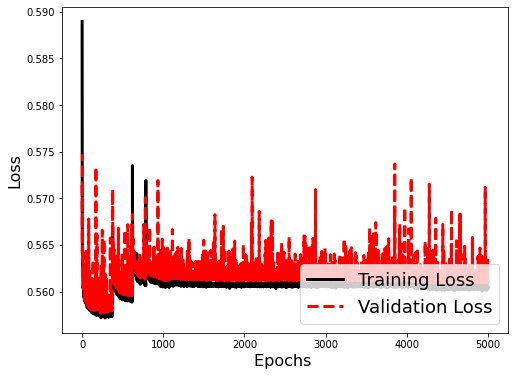

In [ ]:
#printing the loss Function
plt.figure(figsize=[8,6])

plt.plot (history.history['loss'],'black', linewidth=3.0)
plt.plot (history.history['val_loss'],'red', ls= '--' ,linewidth=3.0)
plt.legend(['Training Loss','Validation Loss'],fontsize =18,loc ='lower right')

plt.xlabel('Epochs ', fontsize =16)
plt.ylabel ('Loss', fontsize =16)

Here we see the training loss versus the validation loss after 200 epochs. Interestingly, while there are some spikes in some of the epochs indicating accute increases of the validation loss, in principle it can be seen that the loss has stabilised at a somewhat higher value than the training loss, as is expected of course. After the huge drop of both losses within the first 25 epochs, from that point on the loss has kind of stabilised. (Albeit the spikes)

Text(0, 0.5, 'Accuracy')

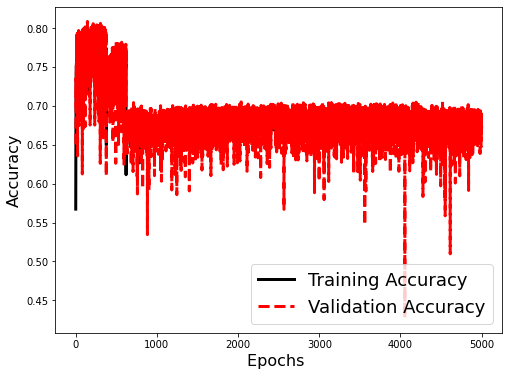

In [ ]:
#printing the Accuracy Function
plt.figure(figsize=[8,6])

plt.plot (history.history['accuracy'],'black', linewidth=3.0)
plt.plot (history.history['val_accuracy'],'red', ls= '--' ,linewidth=3.0)
plt.legend(['Training Accuracy','Validation Accuracy'],fontsize =18,loc ='lower right')

plt.xlabel('Epochs ', fontsize =16)
plt.ylabel ('Accuracy', fontsize =16)

Opposingly to the graphs before, we see how the validation accuracy has huge spikes where the accuracy drops immensely, but at the same time it has a lot of instances where it reaches an accuracy of over 80% while the training data accuracy had solidfied around the 76% area.

# Visualize the results

In [ ]:
decoded_data = model.predict(x_test)
decoded_data.shape

(6000, 32, 32, 3)

In [ ]:
get_encoded_data = Sequential([encoder])
encoded_data = get_encoded_data.predict(x_test)
encoded_data =encoded_data.reshape((len(x_test),16*8*8))
encoded_data.shape

(6000, 1024)

At this point, the latent space representation is of size 1024 for every depth slice

In [ ]:

def show_encoded_data(X , n =10,  height =32, width =32 ,title=""):
  plt.figure(figsize=(10,3))
  for i in range(n):
    ax = plt.subplot(2,n,i+1)
    plt.imshow(X[i].reshape((height,width)))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.suptitle(title, fontsize = 20)

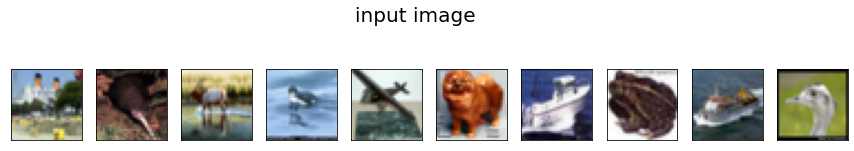

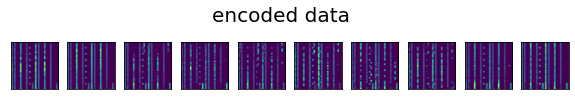

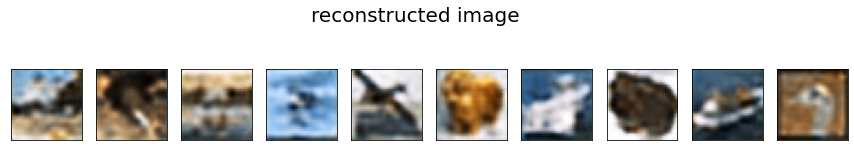

In [ ]:
show_data(x_test, title = 'input image')
show_encoded_data(encoded_data,title = 'encoded data')
show_data(decoded_data, title = 'reconstructed image')


The reconstructed images are obviously blurry, seemingly a result of information loss, but they are very close to their original pictures, though as seen through a blurry lens.

# Extra Experiments results

All the experiments are made with 200 epochs 

***1st Experiment - Change the last activation function***

Results after using the ReLU activation function in all the layers but also in  the last layer of the model. Quite a funny result.
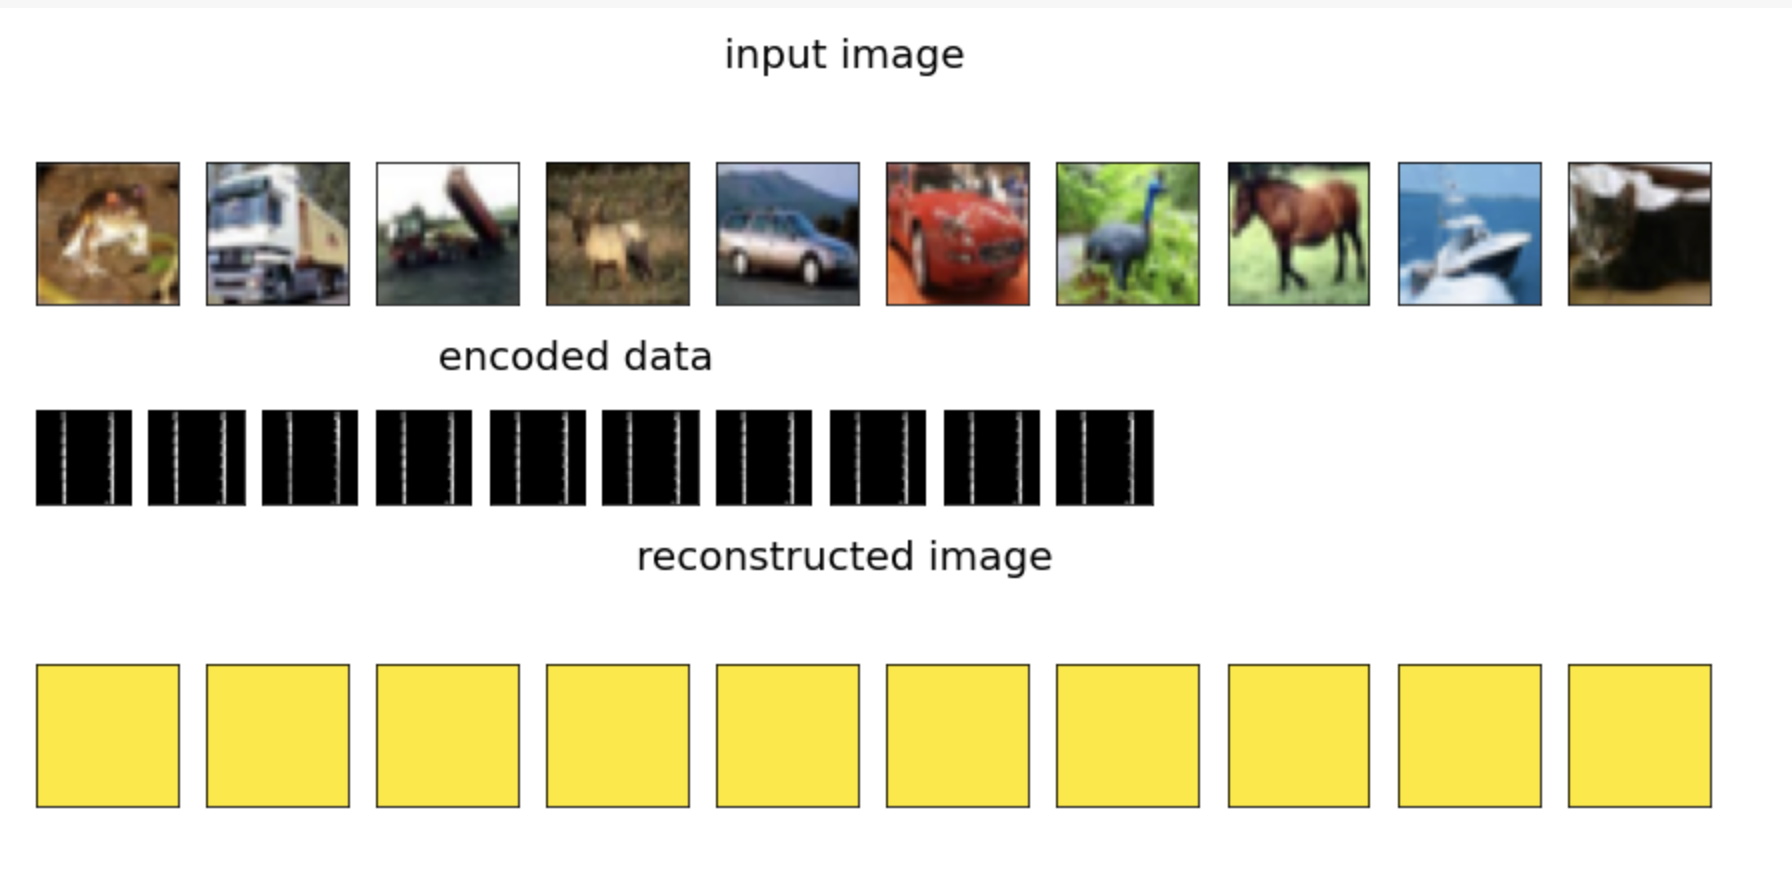

***2nd Experiment - Increase the number of layers***

Results after increasing the filter layers from 9 to 13 of the model, with the beneath sequence.
```
```
For the Encoder
*   Conv2D with 8 channels, 
*   MaxPooling2D(2x2)
*   Conv2D with 12 channels,
*   MaxPooling2D(2x2)
*   Conv2D with 16 channels
*   MaxPooling2D(2x2),
*   Conv2D with 16 channels


```
```

For the Decoder
*   UpSampling2D(2x2)
*   Conv2D with 12 channels
*   UpSampling2D(2x2)
*   Conv2D with 3 channels
*   UpSampling2D(2x2)
*   Conv2D with 3 channels





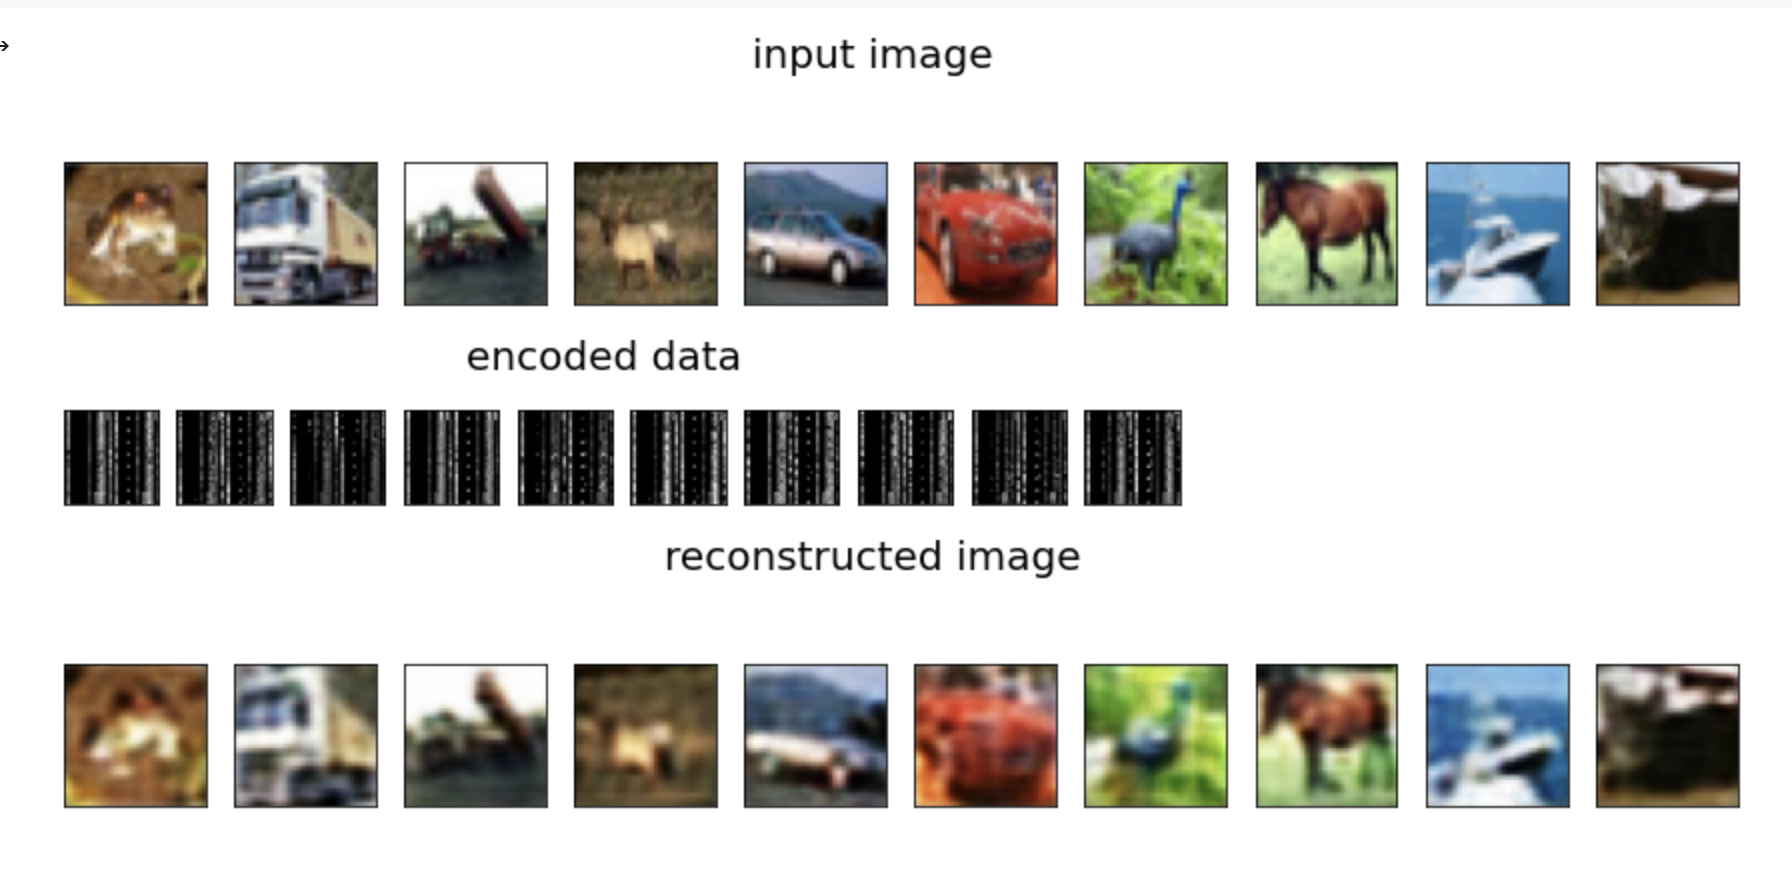

The number of epochs was not enough for very obvious effects, however under careful scrutiny we can see that the increase of the layers has made the images a bit less blurry, though the overal time it took the network to train increased.

***3rd Experiment - Increase the channels in each layer***

Results after changing the number of channels of the model. Instead of [8,12,16,12,3] we used [10,14,18,14,3]:

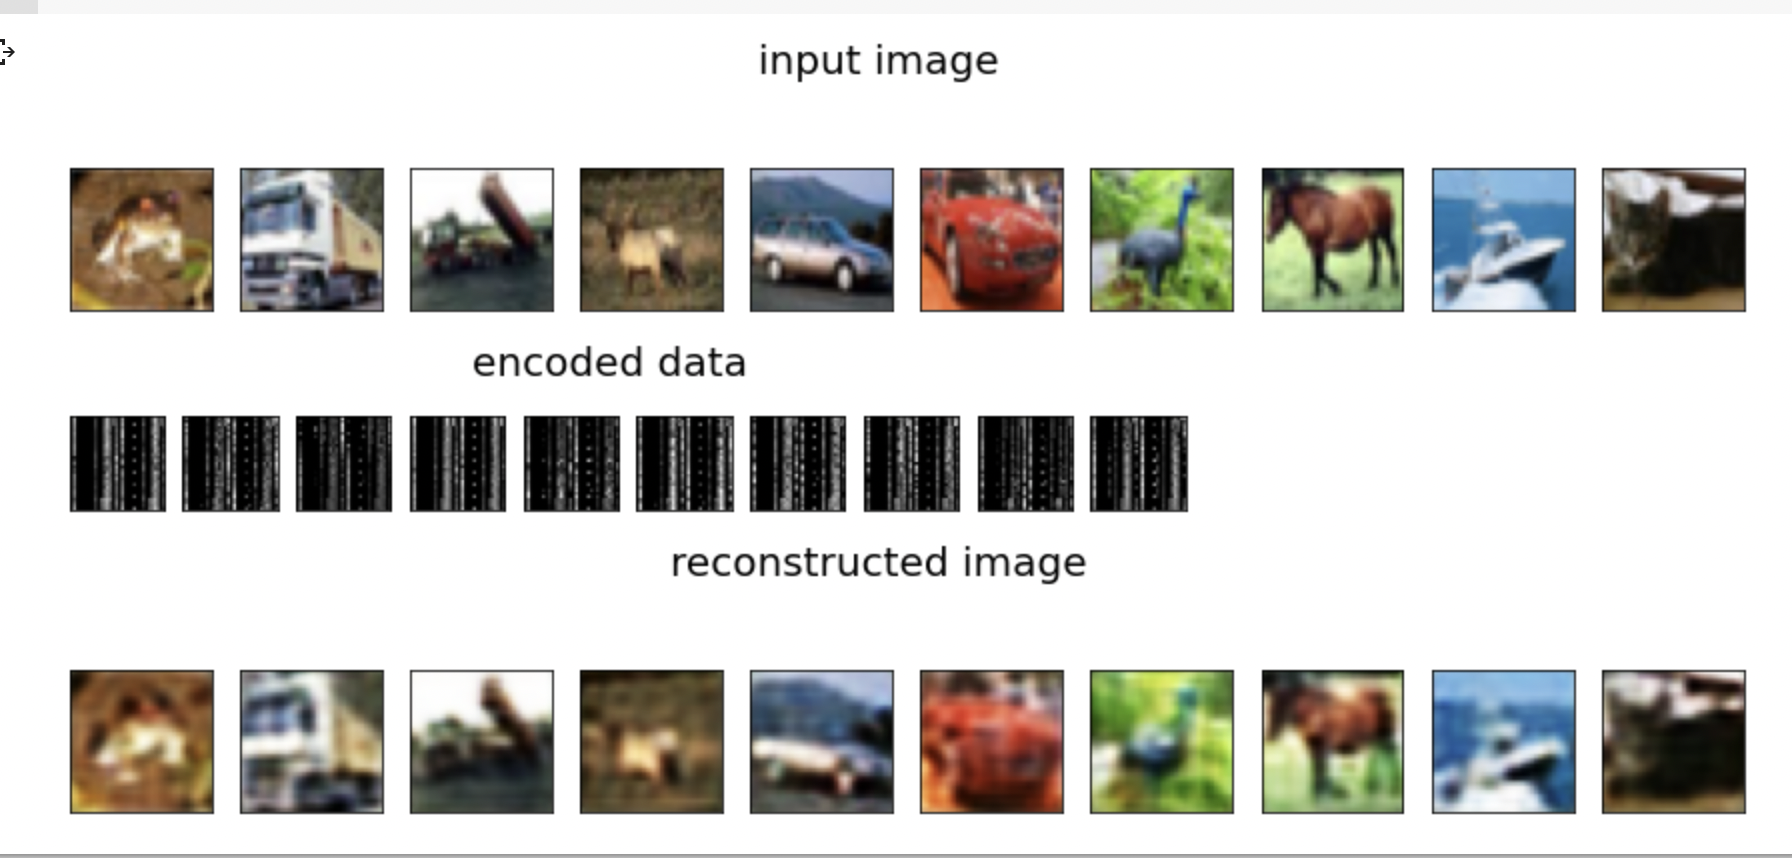

In this experiment the difference from the previous experiment is nearly imperceptible.